# Introduction: Prediction Engineering - Labeling

In this notebook, we will develop a method for labeling customer data for a prediction problem. The objective of labeling is to create a set of historical examples of what we want to predict: in this problem, our goal is to predict customer churn, so we want to label historical customer behavior as churn or not churn. 

The end outcome of this notebook is a set of labels along with cutoff times that can be used in Featuretools for automated feature engineering. These features in turn will be used to train a predictive model to forecast customer churn, a common business need, and one for which machine learning is well-suited.

## Definition of Churn

The data for this problem consists of customer transaction records showing membership to a music streaming service. The definition of churn for this problem is __not having an active membership for a certain number of days.__ The number of days is left as a parameter to adjust based on the particular business need. For example, we can say that churn is no active membership for 30 days or for 14 days depending on the prediction time frame. 

### Transactions Data

For each customer, we have background information (in `members`), logs of listening behavior (in `logs`), and transactions information (in `trans`). The only data we need for labeling is the transactions information.

The transactions data consists of a number of variables, the most important of which are customer id (`msno`), the date of transaction (`transaction_date`), the expiration date of the membership (`membership_expire_date`), and whether or not the transaction represented a cancellation (`is_cancel`). Using these four columns, we find each churn and the corresponding date on which it occurred. Let's look at a few typical examples of customer transaction data to illustrate how to find a churn example. For these examples, we will set the definition of churn as 30 days without an active membership.

__Example 1:__

```
(transaction_date, membership_expire_date, is_cancel)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 0217-03-15, false)

(2017-04-30, 3017-05-20, false)
```
This customer is a churn because they go without a membership for over 30 days, from 03-15 to 04-30. 

__Example 2:__
```
(transaction_date, membership_expire_date, is_cancel)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 2017-04-03, false)

(2017-03-15, 2017-03-16, true)

(2017-04-01, 3017-06-30, false)
```

This customer is not a churn. Even though they have a cancelled membership (cancelled on 03-15 and takes effect on 03-16), the membership plan is renewed within 30 days. 

__Example 3:__
```
(transaction_date, membership_expire_date, is_cancel)

(2017-05-30, 2017-06-30, false)

(2017-07-01, 2017-08-01, false)

(2017-08-01, 2017-09-01, false)

(2017-10-15, 2017-11-15, false)
```
This customer is a churn because they go without a membership for over 30 days, from 09-01 to 10-15. 

These three examples illustrate different situations corresponding to the churn question. 

### Approach

Given the data above, to find each example of churn, we need to find the difference between one `membership_expire_date` and the next `transaction_date`. If this period is greater than the days selected for a churn, then this is a positive example of churn. For each churn, we can find the exact date on which it occurred by adding the number of days for a churn to the `membership_expire_date` associated with the churn. 

We can very rapidly label customer transactions by shifting each `transaction_date` back by one and matching it to the previous `membership_expire_date`. We then find the difference in days between these two (`transaction` - `expire`) and if the difference is greater than the number established for churn, this is a positive label. If this is not clear, we'll shortly see how to do it in code which should clear things up! 

## Prediction Problem

Given the definition of churn and the available transactions data, there are a number of prediction problems that can be asked. A prediction problem is simply a way of framing a business need as a machine learning supervised task. For example, we can choose to make predictions of customer churn at different time points and for different time frames. In this notebook we will look at making predictions at two different points in time. 

* On the first day of every month
* On the first and fifteenth day of every month

We can also vary the number of days required for a customer to be considered a churn. We'll look at two different definitions of churn:

* No active membership for _more than_ 30 days
* No active membership for _more than_ 14 days

Another parameter in terms of a prediction problem is the format of the task. We can predict the churn itself - a __binary yes or no__ - or the __number of days__ until the customer churns - a regression problem. We could even segment the number of days until a churn into multiple groups - say 1-7 days, 8-14 days, 15-21 days and longer - and then make this a multiclass problem. 

To leave the format of the prediction problem (regression or classification) open, in this notebook, we'll find the labels - churn or not - as well as the number of days until the next churn. 

We'll look at two different business scenarios:

1. Making a prediction on the first of the month with the churn period set at 30 days.
2. Making a prediction on the first and fifteenth of the month with the churn period set at 14 days. 

Once we calculate and save these labels for the two different time frames, we can change the exact prediction problem from classification to regression. Moreover, the same features can be used for both classification and regression because they will be calculated based on the same cutoff time. 

## Cutoff Times

In the previous section, we said we'd make predictions either on the 1st and/or 15th of the month. These points at which we make a prediction are referred to as _cutoff_ times and they represent the time all our data for making features for that particular label must be before. For instance, if our cutoff time is July 1, then we are making predictions of customer churn for July, and all of our features for this label must be made with data from before July 1. Cutoff times are a critical consideration when feature engineering in order to prevent data leakage. Featuretools will automatically filter data based on the cutoff times so we don't have to worry about invalid training data.

### Objective

Our overall goal is to build a function that will generate labels for a partition of customers (our data has been partitioned in 1000 segments, each containing a random subset of customers). This function will take in the partition and return two dataframes corresponding to the two prediction problems. With the partitions independent of one another, we can then use Spark to parallelize the labeling operations. Once the label dataframes with cutoff times have been created, we can use them for automated feature engineering using Featuretools.

__With all that in mind (don't worry if it hasn't sunk in yet), let's get started!__

In [4]:
import pandas as pd 
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read in One Data Partition

Each of the 1000 partitions has the membership information, user listening logs, and transactions data for a random subset of customers. The only information we need for labeling is the transactions data. The data is all stored on S3 (make sure to authenticate via S3 using `aws configure` from the command line before reading data).

In [9]:
PARTITION = '100'
base_dir = 's3://customer-churn-spark/partitions/'
directory = base_dir + 'p' + PARTITION

In [10]:
members = pd.read_csv(f'{directory}/members.csv', 
                      parse_dates=['registration_init_time'], infer_datetime_format = True)
trans = pd.read_csv(f'{directory}/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], infer_datetime_format = True)
logs = pd.read_csv(f'{directory}/logs.csv', parse_dates = ['date'])

In [11]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


For each transaction, the important columns are the `transaction_date` and the `membership_expire_date`. Using these two columns, we can determine if a customer has churned. 

## Remove Anomalies

There are a number of records in the transactions where the `membership_expire_date` is before the `transaction_date`. We will remove these to prevent them from creating issues with our labeling.

In [12]:
trans = trans.loc[trans['membership_expire_date'] >= trans['transaction_date']]

Some of the transactions occur on the same day for the same customer (there probably was once a time associated with these transactions that was removed). In these cases, we will assume that the transaction with the later `membership_expire_date` happened second. What I think these same-day transactions represent is a customer signing up for one plan, then receiving a new offer (that they think is a better deal) on the same day and switching to a different plan. 

In [13]:
trans = trans.sort_values(['msno', 'transaction_date', 'membership_expire_date'])

In [14]:
# View value counts of customers
trans.groupby('msno').count().sort_values('is_cancel').tail()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
msno,,,,,,,,
5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,39,39,39,39,39,39,39,39
CNVTd5cNoA6WRxMf7VveVwYyrOoDgFs5xmm1122qQNc=,39,39,39,39,39,39,39,39
kA7JMc6Q6nAFw1fgcs0hejCw4xXaGUzB/eq+M5n21wQ=,40,40,40,40,40,40,40,40
mFsXs71TCuJOnHKWQQ271BdecYkrXgPIRU7VUfmtqAY=,42,42,42,42,42,42,42,42
/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,51,51,51,51,51,51,51,51


We'll work with the data from one customer at first. 

In [28]:
customer_id = '/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM='
cust = trans.loc[trans['msno'] == customer_id].copy()
cust.iloc[:, 1:].tail(6)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
12519,41,30,129,129,1,2016-11-08,2016-12-08,0
7776,41,30,129,129,1,2016-11-14,2016-11-14,1
1504,41,30,99,99,1,2016-11-14,2016-12-13,0
5462,41,30,99,99,1,2016-12-13,2017-01-13,0
10717,41,30,99,99,1,2017-01-13,2017-02-13,0
21899,41,30,99,99,1,2017-03-13,2017-04-13,0


# Identify Customer Churns

To find a churn, we'll need to calculate the number of days from the end of one active membership to the start of the next. We'll  find each `membership_expire_date`, and determine the number of days until the next `transaction_date` for the customer.  This gap represents the number of days the customer was not an active member. 

Once we have the gaps, we can compare them to any definition of churn - for example 14 days - to determine which transactions represents churns and when it occurs.

In [29]:
cust = cust.sort_values(['transaction_date', 'membership_expire_date']).reset_index(drop = True)

## Vectorized Operation

The most efficient method for carrying out calculations in Pandas is with vectorization. In the case of finding customer churns, we can make the calculating a vector subtraction by `shift`ing the `transaction_date` one spot back to align with the previous `membership_expire_date`. We then find the difference in days between the shifted transaction date and the membership expiration date. This `gap` is exactly what we are looking for to determine churn.

In [30]:
cust['gap'] = (cust['transaction_date'].shift(-1) - cust['membership_expire_date']).dt.days 
cust.iloc[-15:, 1:]

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,gap
36,41,30,149,149,1,2016-02-21,2016-03-21,0,0.0
37,41,30,149,149,1,2016-03-21,2016-04-21,0,-12.0
38,41,30,129,129,1,2016-04-09,2016-05-08,0,0.0
39,41,30,129,129,1,2016-05-08,2016-06-08,0,0.0
40,41,30,129,129,1,2016-06-08,2016-07-08,0,0.0
41,41,30,129,129,1,2016-07-08,2016-08-08,0,0.0
42,41,30,129,129,1,2016-08-08,2016-09-08,0,0.0
43,41,30,129,129,1,2016-09-08,2016-10-08,0,0.0
44,41,30,129,129,1,2016-10-08,2016-11-08,0,0.0
45,41,30,129,129,1,2016-11-08,2016-12-08,0,-24.0


This customer has one large gap between active memberships of 28 days. Depending on the parameter we can set, this may or may not be a churn. 

## Date of Churn

If there is a churn, then we need to find out when it occurred in order to calculate the month of the churn and the days until churn. We'll set the churn period as 14 days to work with this example. 

To find the churn date for a positive label, we add the number of days for a churn to the `membership_expire_date` associated with the churn.

In [31]:
# Days without membership to be considered a churn
periods = 14

# Determine if churned occur
cust['churn'] = cust['gap'] > periods

# If customer did churn set the churn date
cust.loc[cust['churn'] == 1, 'churn_date'] = cust.loc[cust['churn'] == 1, 
                                                      'membership_expire_date'] + pd.Timedelta(periods + 1, 
                                                                                               unit = 'd')
cust.iloc[:5, 6:]
cust.iloc[-5:, 6:]

,transaction_date,membership_expire_date,is_cancel,gap,churn,churn_date
0,2015-01-13,2016-12-15,0,-694.0,False,NaT
1,2015-01-21,2017-01-15,0,-720.0,False,NaT
2,2015-01-26,2017-02-15,0,-733.0,False,NaT
3,2015-02-13,2017-03-15,0,-753.0,False,NaT
4,2015-02-21,2017-04-12,0,-776.0,False,NaT


,transaction_date,membership_expire_date,is_cancel,gap,churn,churn_date
46,2016-11-14,2016-11-14,1,0.0,False,NaT
47,2016-11-14,2016-12-13,0,0.0,False,NaT
48,2016-12-13,2017-01-13,0,0.0,False,NaT
49,2017-01-13,2017-02-13,0,28.0,True,2017-02-28
50,2017-03-13,2017-04-13,0,NaN,False,NaT


# Make Cutoff Times

We want to make predictions either on the 1st only or on the 1st and 15th of each month. We first need to make the cutoff times and then we can associate the labels (churn yes/no and number of days until the next churn) for each cutoff time. 

We'll start by making a date range for the entire time a customer was a member. To make a date range for the first of every month we can use `MS` frequency, and for the first and fifteenth of every month, the `SMS` frequency.

#### First of Month Frequency

In [32]:
# Calculate date range for labels
first_trans = cust['transaction_date'].min()
last_member = cust['membership_expire_date'].max()
start_date = pd.datetime(first_trans.year, first_trans.month, 1)
end_date = pd.datetime(last_member.year, last_member.month, 1)

# Create a range of dates for labels 
# 'MS' = month starts, 'SMS': twice a month on 1 and 15.
date_range = pd.date_range(start_date, end_date, freq = 'MS')
date_range[:5]
date_range[-5:]

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01'],
              dtype='datetime64[ns]', freq='MS')

DatetimeIndex(['2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01'],
              dtype='datetime64[ns]', freq='MS')

#### First and Fifteenth of Month Frequency

In [33]:
date_range_t = pd.date_range(start_date, end_date, freq = 'SMS')
date_range_t[:5]
date_range_t[-5:]

DatetimeIndex(['2015-01-01', '2015-01-15', '2015-02-01', '2015-02-15',
               '2015-03-01'],
              dtype='datetime64[ns]', freq='SMS-15')

DatetimeIndex(['2019-08-01', '2019-08-15', '2019-09-01', '2019-09-15',
               '2019-10-01'],
              dtype='datetime64[ns]', freq='SMS-15')

## Making Labels

Now, for each cutoff time, we need to decide whether or not a churn occured after the cutoff time and before the next cutoff time. If it did, the label for this cutoff time is a 1. We also want to calculate the number of days until the next churn for each cutoff time so we can make a regression problem if needed.

In [34]:
# Make a label dataframe
labels = pd.DataFrame({'cutoff_time': date_range})
labels['next_cutoff_time'] = labels['cutoff_time'].shift(-1)
labels['msno'] = customer_id

labels.head()

,cutoff_time,next_cutoff_time,msno
0,2015-01-01,2015-02-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=
1,2015-02-01,2015-03-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=
2,2015-03-01,2015-04-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=
3,2015-04-01,2015-05-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=
4,2015-05-01,2015-06-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=


If there are no churns, then this is an easy data frame to make.

In [36]:
# Handle case where there are no churns
if not np.any(cust['churn'] == 1):
    labels['churn'] = 0
    labels['days_to_next_churn'] = np.nan

In this case (churn set to 14 days) we do have one churn.

Next we want to iterate through each churn, and assign the labels to the correct cutoff time. To do this, we find the cutoff time directly before the date of churn (`churn_date`). Then, to find the number of days until the churn for that given churn, we subset the `label` dataframe to cutoff times before the churn (but after the previous churn if there was one) and calculate the number of days from the cutoff time until the churn.

In [37]:
previous_churn = None

# Iterate through the churn dates
for churn_date in cust.loc[cust['churn_date'].notnull(), 'churn_date']:

    # Assign the label 1 if the customer churned during the cutoff_time period
    labels.loc[(labels['cutoff_time'] <= churn_date) & (labels['next_cutoff_time'] > churn_date), 'churn'] = 1

    if previous_churn is not None:
        # Subset to cutoff times after the previous churn but on or before the current churn
        before_churn_idx = labels.loc[(labels['cutoff_time'] > previous_churn) & 
                                      (labels['cutoff_time'] <= churn_date)].index       
   
    # No previous churn
    else:
         # Subset to cutoff times on or before the current churn
        before_churn_idx = labels.loc[labels['cutoff_time'] <= churn_date].index
        
     # Calculate the days until the churn
    labels.loc[before_churn_idx, 'days_to_next_churn'] = (churn_date - labels.loc[before_churn_idx, 'cutoff_time']).dt.days
    previous_churn = churn_date

# Fill in missing churns with 0
labels['churn'] = labels['churn'].fillna(0)

In [42]:
labels.iloc[20:30]
cust.iloc[-4:, 6:]

,cutoff_time,next_cutoff_time,msno,churn,days_to_next_churn
20,2016-09-01,2016-10-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,180.0
21,2016-10-01,2016-11-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,150.0
22,2016-11-01,2016-12-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,119.0
23,2016-12-01,2017-01-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,89.0
24,2017-01-01,2017-02-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,58.0
25,2017-02-01,2017-03-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,1.0,27.0
26,2017-03-01,2017-04-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,NaN
27,2017-04-01,2017-05-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,NaN
28,2017-05-01,2017-06-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,NaN
29,2017-06-01,2017-07-01,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,0.0,NaN


,transaction_date,membership_expire_date,is_cancel,gap,churn,churn_date
47,2016-11-14,2016-12-13,0,0.0,False,NaT
48,2016-12-13,2017-01-13,0,0.0,False,NaT
49,2017-01-13,2017-02-13,0,28.0,True,2017-02-28
50,2017-03-13,2017-04-13,0,NaN,False,NaT


The code looks like it works! For each churn, we have the label during the correct time period when it occurred, and for each cutoff time before the churn, the number of days until the churn occurred.

In [55]:
(labels.loc[labels['churn'] == 1, 'cutoff_time']).values[0]

numpy.datetime64('2017-02-01T00:00:00.000000000')

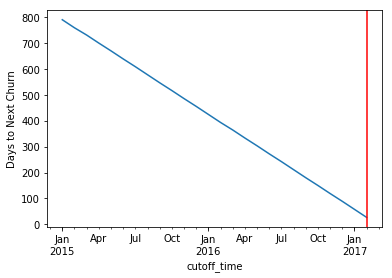

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
labels.set_index('cutoff_time')['days_to_next_churn'].plot();
plt.axvline(x = (labels.loc[labels['churn'] == 1, 'cutoff_time']).values[0], color = 'r');
plt.ylabel('Days to Next Churn');

The rest of the cutoff times do not have any churn and hence the days to next churn is undefined. Using these two labels, we can frame the problem as either regression or classification.

# Labeling Function

Now that we have working code, we can refactor it into a function. This function takes in a customer id, the transactions dataframe, the label type (either 1st of  month or 1st and 15th of month), and the number of days without a membership considered a churn (either 14 or 30). The dataframe returned contains the cutoff times, binary labels, and regression labels.

In [59]:
def generate_labels(customer_id, trans, label_type, churn_period = 30, return_cust = False):
    """Make labels for one customer for one period
    Params
    --------
        customer_id (str): string used to select customer
        trans (dataframe): transactions for customers
        label_type (str): either 'MS' for monthly labels at the start of the month or 
                          'SMS' for twice a month labels (on 1 and 15 of month)
        churn_period (int): number of days without membership required for a churn [default 30 days]
        return_cust (bool): whether or not to return the customer dataframe. Useful for debugging
        
    Return
    --------
        labels (dataframe): labels for all months in customer history
                            columns are ['msno', 'cutoff', 'churn', 'days_to_next_churn']
        cust (dataframe): if return_cust == True, a dataframe of the customers transactions
    """
    assert label_type in ['MS', 'SMS'], 'label_type must be either "MS" or "SMS"'
    
    cust = trans.loc[trans['msno'] == customer_id].copy()
    
    # Make sure to sort transactions and drop the index
    cust = cust.sort_values(['transaction_date', 'membership_expire_date']).reset_index(drop = True)
    
    # Find gap between membership expiration and start of next membership
    cust['gap'] = (cust['transaction_date'].shift(-1) - cust['membership_expire_date']).dt.days 
    
    # Determine if churn occur
    cust.loc[cust['gap'] > churn_period, 'churn']  = 1
    cust.loc[cust['gap'] <= churn_period, 'churn'] = 0
    
    # Calculate date range for labels
    first_trans = cust['transaction_date'].min()
    last_member = cust['membership_expire_date'].max()
    start_date = pd.datetime(first_trans.year, first_trans.month, 1)
    end_date = pd.datetime(last_member.year, last_member.month, 1)

    # Create a range of dates for labels 
    # 'MS' = month starts, 'SM': twice a month on 15 and end.
    date_range = pd.date_range(start_date, end_date, freq = label_type)
    
    # Create a label dataframe
    labels = pd.DataFrame({'cutoff_time': date_range})
    labels['next_cutoff_time'] = labels['cutoff_time'].shift(-1)
    labels['msno'] = customer_id
    
    # Handle case where there are no churns
    if not np.any(cust['churn'] == 1):
        labels['churn'] = 0
        labels['days_to_next_churn'] = np.nan
        return labels[['msno', 'cutoff_time', 'churn', 'days_to_next_churn']]
    
    # If customer did churn set the churn date
    cust.loc[cust['churn'] == 1, 'churn_date'] = cust.loc[cust['churn'] == 1, 
                                                'membership_expire_date'] + pd.Timedelta(periods + 1, 
                                                                                         unit = 'd')
    
    previous_churn = None

    # Iterate through the churn dates
    for churn_date in cust.loc[cust['churn_date'].notnull(), 'churn_date']:

        # Assign the label 1 if the customer churned during the cutoff_time period
        labels.loc[(labels['cutoff_time'] <= churn_date) & (labels['next_cutoff_time'] > churn_date), 'churn'] = 1

        if previous_churn is not None:
            # Subset to cutoff times after the previous churn but on or before the current churn
            before_churn_idx = labels.loc[(labels['cutoff_time'] > previous_churn) & 
                                          (labels['cutoff_time'] <= churn_date)].index       

        # No previous churn
        else:
             # Subset to cutoff times on or before the current churn
            before_churn_idx = labels.loc[labels['cutoff_time'] <= churn_date].index

         # Calculate the days until the churn
        labels.loc[before_churn_idx, 'days_to_next_churn'] = (churn_date - labels.loc[before_churn_idx, 'cutoff_time']).dt.days
        previous_churn = churn_date

    # Fill in missing churns with 0
    labels['churn'] = labels['churn'].fillna(0)
    
    # Sometimes want to return customer information for debugging
    if return_cust:
        return cust, labels[['msno', 'cutoff_time', 'churn', 'days_to_next_churn']]
    
    # Subset to relevant columns
    return labels[['msno', 'cutoff_time', 'churn', 'days_to_next_churn']]

Using our example customer, we can set the churn period to 14 days to get one churn or to 30 days to get no churns.

In [61]:
cutoff_times = generate_labels('/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=', trans, 
                               label_type = 'MS', churn_period = 14)
cutoff_times[cutoff_times['churn'] == 1].head()

,msno,cutoff_time,churn,days_to_next_churn
25,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,2017-02-01,1.0,27.0


In [62]:
cutoff_times = generate_labels('/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=',  trans,
                               label_type = 'MS', churn_period = 30)
cutoff_times[cutoff_times['churn'] == 1].head()

,msno,cutoff_time,churn,days_to_next_churn


Let's try the same customer but using the 1st and 15th of each month as the cutoff times.

In [63]:
cutoff_times = generate_labels('/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=',  trans,
                               label_type = 'SMS', churn_period = 14)
cutoff_times[cutoff_times['churn'] == 1].head()

,msno,cutoff_time,churn,days_to_next_churn
51,/7/KMLZlMBnmWtb9NNkm3bYMQHWrt0C1BChb62EiQLM=,2017-02-15,1.0,13.0


Let's try a few more customers.

In [65]:
cutoff_times = generate_labels('5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=', trans,
                               label_type = 'MS', churn_period = 30)
cutoff_times.head()

,msno,cutoff_time,churn,days_to_next_churn
0,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-01-01,0,NaN
1,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-02-01,0,NaN
2,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-03-01,0,NaN
3,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-04-01,0,NaN
4,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-05-01,0,NaN


In [66]:
cutoff_times = generate_labels('5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=', trans,
                               label_type = 'SMS', churn_period = 14)
cutoff_times.head()

,msno,cutoff_time,churn,days_to_next_churn
0,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-01-01,0,NaN
1,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-01-15,0,NaN
2,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-02-01,0,NaN
3,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-02-15,0,NaN
4,5fPXqLcScoC93rH/gCPK+5Soj+XdNMXX9S3LhV5dJjM=,2015-03-01,0,NaN


## Entire Labeled Partition

The goal is a function that labels an entire partition for both prediction problems. Let's use the labeling function `generate_labels` to iterate through the selected partition and make all of the labels.

In [67]:
from timeit import default_timer as timer

start = timer()

cutoff_list = []

# Iterate through every customer
for customer_id in trans['msno'].unique():
    cutoff_list.append(generate_labels(customer_id, trans, label_type = 'MS', churn_period = 30))
    
cutoff_times = pd.concat(cutoff_list)
end = timer()
print(f'{round(end - start)} seconds elapsed.')

24 seconds elapsed.


In [70]:
print(f'There are {len(cutoff_times)} 1st of the month cutoff times in partition {PARTITION}.')

There are 30244 1st of the month cutoff times in partition 100.


Let's look at some customers that do have churns identified to make sure the function is working as intended.

In [71]:
cutoff_times.groupby('msno')['churn'].sum().sort_values().tail()

msno
kZmdjgljzQXsQlVdL0Uc0eAtJs4PJ1I/dFVXEA89JUU=    4.0
TgdYZSvjnJf3SJdoBgtlEuU5o/Lw6+6Cr3nvdHMexhA=    4.0
T7UnacSE9cXizWOekvD3R+FgPuroIdL46aBRGy0yf1s=    4.0
kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=    5.0
jdYSK7I9TjjADXtMsv8vhN362hfIfC0Qyrn4fSZNHKY=    5.0
Name: churn, dtype: float64

In [72]:
cust, c = generate_labels('kZmdjgljzQXsQlVdL0Uc0eAtJs4PJ1I/dFVXEA89JUU=', trans, 
                          label_type = 'MS', churn_period = 30, return_cust = True)

In [73]:
c[c['days_to_next_churn'] < 30]

,msno,cutoff_time,churn,days_to_next_churn
7,kZmdjgljzQXsQlVdL0Uc0eAtJs4PJ1I/dFVXEA89JUU=,2015-09-01,1.0,14.0
11,kZmdjgljzQXsQlVdL0Uc0eAtJs4PJ1I/dFVXEA89JUU=,2016-01-01,1.0,4.0
15,kZmdjgljzQXsQlVdL0Uc0eAtJs4PJ1I/dFVXEA89JUU=,2016-05-01,1.0,2.0
17,kZmdjgljzQXsQlVdL0Uc0eAtJs4PJ1I/dFVXEA89JUU=,2016-07-01,1.0,11.0


In [79]:
cust.iloc[:8, 6:]

,transaction_date,membership_expire_date,is_cancel,gap,churn,churn_date
0,2015-02-14,2015-08-31,0,48.0,1.0,2015-09-15
1,2015-10-18,2015-11-17,0,4.0,0.0,NaT
2,2015-11-21,2015-12-21,0,36.0,1.0,2016-01-05
3,2016-01-26,2016-02-25,0,23.0,0.0,NaT
4,2016-03-19,2016-04-18,0,40.0,1.0,2016-05-03
5,2016-05-28,2016-06-27,0,38.0,1.0,2016-07-12
6,2016-08-04,2016-09-03,0,17.0,0.0,NaT
7,2016-09-20,2016-10-20,0,1.0,0.0,NaT


Everything looks to be good for this customer. For each case in which he/she had a gap longer than the period defined for a churn, the label is associated with the correct cutoff time and the days to the next churn are calculated accurately.

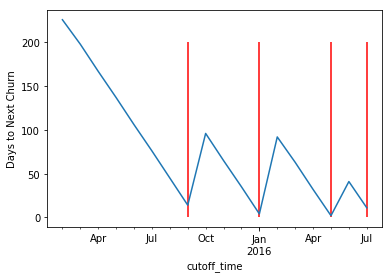

In [83]:
c.set_index('cutoff_time')['days_to_next_churn'].plot();
plt.vlines(x = (c.loc[c['churn'] == 1, 'cutoff_time']).values, ymin = 0, ymax = 200, color = 'r');
plt.ylabel('Days to Next Churn');

In [84]:
cust, c = generate_labels('kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=', trans, 
                          label_type = 'MS', churn_period = 30, return_cust = True)

In [85]:
c[c['days_to_next_churn'] < 30]

,msno,cutoff_time,churn,days_to_next_churn
1,kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=,2015-08-01,1.0,21.0
6,kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=,2016-01-01,1.0,27.0
15,kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=,2016-10-01,1.0,6.0
17,kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=,2016-12-01,1.0,24.0
20,kP7RKKr5iyF2/oozQSsahJn+7f8ugx6jeZ7rlrV9lQA=,2017-03-01,1.0,7.0


In [87]:
cust.iloc[:, 6:]

,transaction_date,membership_expire_date,is_cancel,gap,churn,churn_date
0,2015-07-08,2015-08-07,0,95.0,1.0,2015-08-22
1,2015-11-10,2015-12-10,0,4.0,0.0,NaT
2,2015-12-14,2016-01-13,0,163.0,1.0,2016-01-28
3,2016-06-24,2016-07-24,0,30.0,0.0,NaT
4,2016-08-23,2016-09-22,0,42.0,1.0,2016-10-07
5,2016-11-03,2016-11-10,0,-7.0,0.0,NaT
6,2016-11-03,2016-12-10,0,43.0,1.0,2016-12-25
7,2017-01-22,2017-02-21,0,31.0,1.0,2017-03-08
8,2017-03-24,2017-04-23,0,NaN,NaN,NaT


The cutoff times and labels again seem to be correct.

If the churn occurs on the first of the month, then the days to next churn should be 0. This presents a bit of a corner case, so let's take a look at one example.

In [91]:
cutoff_times.loc[cutoff_times['days_to_next_churn'] == 0]

,msno,cutoff_time,churn,days_to_next_churn
15,5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=,2016-08-01,1.0,0.0
23,PyT229LYRSc1VWWokMA9qLZQcd7ZfuYpEP3E9J111Lc=,2017-02-01,1.0,0.0
8,RayIk44G3CMQLttkwvJ2J9m57sXbOXYe9MTj5orzKrg=,2016-01-01,1.0,0.0
1,cN+xQ29nIRPOq1YnHJtkDv2P33loVA3XTVM8moLpB7Q=,2015-02-01,1.0,0.0
3,cN+xQ29nIRPOq1YnHJtkDv2P33loVA3XTVM8moLpB7Q=,2015-04-01,1.0,0.0
2,ukeuAlw/yINUI62KOoOt7cSsVVmPcV0zkM8pa2kA7LI=,2015-07-01,1.0,0.0


In [96]:
cust, c = generate_labels('5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=', trans, 
                          label_type = 'MS', churn_period = 30, return_cust = True)

c.iloc[15:20]
cust.iloc[:, 6:]

,msno,cutoff_time,churn,days_to_next_churn
15,5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=,2016-08-01,1.0,0.0
16,5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=,2016-09-01,0.0,NaN
17,5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=,2016-10-01,0.0,NaN
18,5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=,2016-11-01,0.0,NaN
19,5Jp8Y1PqL2sVd9rhoeMiAP836V5xlll3y+MOj2bN8pM=,2016-12-01,0.0,NaN


,transaction_date,membership_expire_date,is_cancel,gap,churn,churn_date
0,2015-05-10,2015-11-21,0,44.0,1.0,2015-12-06
1,2016-01-04,2016-07-17,0,113.0,1.0,2016-08-01
2,2016-11-07,2017-05-24,0,NaN,NaN,NaT


Now that we can be confident our function works as intended for the 1st of the month labels, we should check it on an entire partition for the 1st and 15th of the month. This time we will use 14 days as the churn period.

In [ ]:
start = timer()
cutoff_list = []
# Iterate through every customer

for customer_id in trans['msno'].unique():
    # Setting label type to 1st and 15th
    cutoff_list.append(generate_labels(customer_id, trans, label_type = 'SMS', churn_period = 14))
    
cutoff_times = pd.concat(cutoff_list)
end = timer()
print(f'{round(end - start)} seconds elapsed.')

In [ ]:
print(f'There are {len(cutoff_times)} first and fifteenth of the month labels for partition {PARTITION}.')

In [ ]:
cutoff_times.groupby('msno')['churn'].sum().sort_values().tail()

In [ ]:
cust, c = generate_labels('jdYSK7I9TjjADXtMsv8vhN362hfIfC0Qyrn4fSZNHKY=', trans, 
                          label_type = 'MS', churn_period = 30, return_cust = True)

c.iloc[15:20]
cust.iloc[:, 6:]

# All Labels for Partition 

The next step is to write a function that can make the month labels for a partition. It will accept a partition number and generate the partition labels. These will then be saved to the partition directory.

In [40]:
partitions = list(range(len(os.listdir('/data/churn/partitions/'))))
partitions[-1]

999

In [41]:
def partition_to_labels(partition, label_type, churn_period):
    """Make labels for all customers in one partition
    Either for one month or twice a month
    
    Params
    --------
        partition (int): number of partition
        label_type (str): either 'monthly' for monthly labels or
                          'bimonthly' for twice a month labels
        churn_period (int): number of days required without a membership for a churn
    
    Returns
    --------
        None: saves the label dataframes with the appropriate name to the partition directory
    """
    
    # Read in data and filter anomalies
    trans = pd.read_csv(f'{base_dir}p{partition}/transactions.csv',
                        parse_dates=['transaction_date', 'membership_expire_date'], 
                        infer_datetime_format = True)
    trans = trans.loc[trans['membership_expire_date'] >= trans['transaction_date']]
    
    cutoff_list = []

    if label_type == 'monthly':
        # Iterate through every customer
        for customer_id in trans['msno'].unique():
            cutoff_list.append(generate_labels(customer_id, trans, label_type = 'MS', churn_period = churn_period))
        cutoff_times = pd.concat(cutoff_list)
        cutoff_times.to_csv(f'{base_dir}p{partition}/monthly_labels_{churn_period}.csv', index = False)
        
    
    elif label_type == 'bimonthly':
        for customer_id in trans['msno'].unique():
            cutoff_list.append(generate_labels(customer_id, trans, label_type = 'SMS', churn_period = churn_period))
        cutoff_times = pd.concat(cutoff_list)
        cutoff_times.to_csv(f'{base_dir}p{partition}/bimonthly_labels_{churn_period}.csv', index = False)

In [42]:
partition_to_labels(1)

TypeError: partition_to_labels() missing 2 required positional arguments: 'label_type' and 'churn_period'

In [ ]:
partition_to_labels(50)

# Two Week Labels

Next we'll work on making labels in two-week increments. This time, the question is not whether the customer churned during the subsequent month, but whether the customer churned in the two weeks following the `cutoff_time`.

In [ ]:
import dask.bag as db
from dask.distributed import Client

# Use all cores
client = Client(processes = True)

In [ ]:
client.ncores()

In [ ]:
# Create a bag object
b = db.from_sequence(partitions, npartitions=len(partitions))

# Map partition making function
b = b.map(make_partition_labels)
    
b

In [ ]:
%%capture
from timeit import default_timer as timer

start = timer()
b.compute()
end = timer()



In [ ]:
print(f'{round(end - start)} seconds elapsed.')

# Conclusions

In this notebook, we generated labels and cutoff time dataframes for each partition. We can then use these cutoff times in a call to deep feature synthesis to make features for each label. 

The next notebook is `Feature Engineering`. 

In [ ]:
pd.date_range(pd.datetime(2010, 1, 1), pd.datetime(2012, 1, 1), freq = '2W-MON')